# ARIMA Model

## Content
* Elements
* Data Preprocessing
* Model Identification
* Model Estimation
* Model Verification
* Model Use

Import required tools

In [2]:
import time
import itertools
import joblib
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Get requiered config

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
# Show all columns ans rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Preprocessing

### Load data

In [4]:
# Load data
loading_path = r'/Users/rlg/Desktop/Workspace/data/df_inflation.csv'
df = pd.read_csv(loading_path)
df.head()

,DS,INFLACION,MXN/USD,AG_MONET_M2,TASA_INT,REMESAS,SM_NOM_GENERAL,SM_NOM_ZLFN,PIB_PCONST_VAR_ANUAL_TRIM
0,1/1/2021,3.54,19.9215,10434950530,4.30,3392808480,141.7,213.39,-2.594806
1,2/1/2021,3.76,20.3097,10406909432,4.11,3264101525,141.7,213.39,-2.594806
2,3/1/2021,4.67,20.7555,10516385860,4.02,4275093702,141.7,213.39,-2.594806
3,4/1/2021,6.08,20.0153,10517260240,4.01,4167759579,141.7,213.39,22.702244
4,5/1/2021,5.89,19.9631,10535614830,4.04,4677325083,141.7,213.39,22.702244


In [5]:
# Select required data
df = df[['DS', 'INFLACION']]
# Make sure dates are fine
df['DS'] = pd.to_datetime(df['DS'], format='mixed')
# Save dates for further forecast  evaluation 
df_future = df[df['DS'] >= '2025-01-01'] # For forecast evaluation
df = df[df['DS'] < '2025-01-01']
# Change column names
df = df.rename(columns={'DS': 'ds', 'INFLACION': 'y'})
df_future = df_future.rename(columns = {'DS' : 'ds', 'INFLACION' : 'y'})
# Set DS as index
endog = pd.Series(df['y'].values, index=df['ds'])
endog_future = pd.Series(df_future['y'].values, index = df_future['ds'])
# See data
endog.head()

ds
2021-01-01    3.54
2021-02-01    3.76
2021-03-01    4.67
2021-04-01    6.08
2021-05-01    5.89
dtype: float64

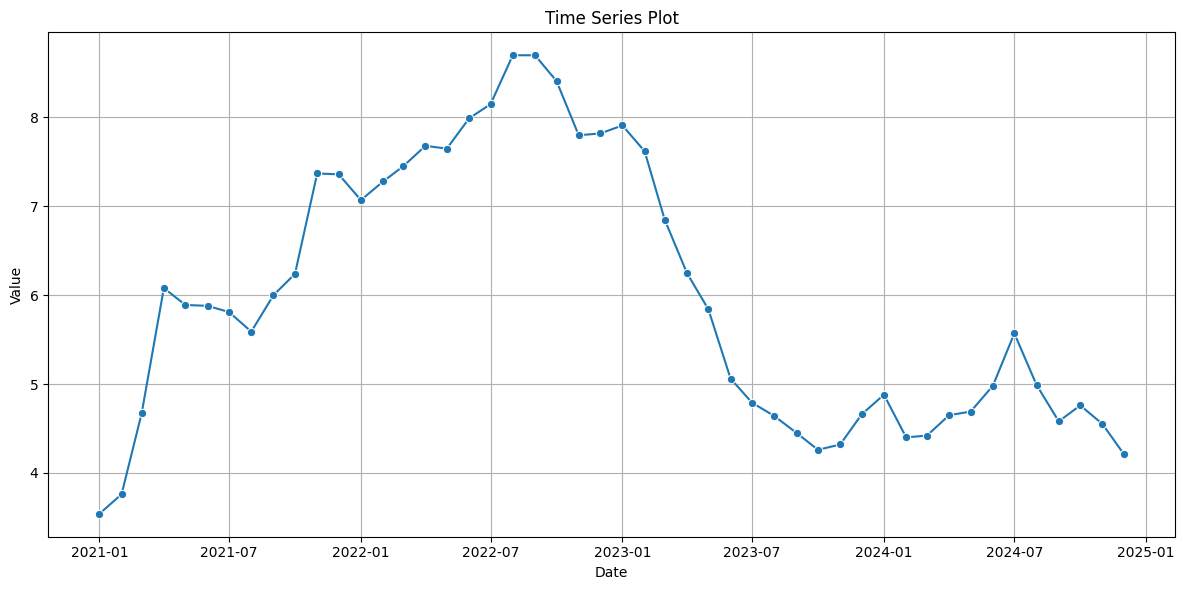

In [6]:
# Plot data
plt.figure(figsize=(12, 6))
sns.lineplot(data = endog, marker = 'o')
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Identification
This section finds the best $(p,I,q)$ parameters of an ARIMA model in order to get the best fit with the required data with the following approch:
* Grid search with in-sample metrics ($MAPE$, $R^2$, $MAE$, $AIC$) over  $p,I,q$  parameters and Box-Cox transformation.

### Grid Search (In-Sample Metrics)

In [7]:
# Parameter grid
param_grid = {
    'AR_p' : [0,1,2],
    'MA_q' : [0,1,2],
    'I': [0,1,2],
    'Box-Cox' : [True, False]
}

In [8]:
# Import required tools
from itertools import product
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error


# Hyperparameter grid search function
def ARIMA_GRID_SEARCH_IN_SAMPLE(endog, param_grid, freq):
    """
    ARIMA Hyperparameter Grid Search with In-Sample Evaluation

    IN:
    -> endog: endogenous variables at present time (pd.Series)
    -> param_grid: hyperparameter grid to search over (dict)
    -> bc_transform: whether to apply Box-Cox transformation (bool)
    -> freq: frequency of the time series data (str)

    OUT:
    -> df_metrics: Table with hyperparameters combinations and its corresponing in-sample metrics (pandas.DataFrame)
    """ 
    # Print total iterations
    print('Total Iterations: ', len(list(product(*param_grid.values()))))

    # Initialize metrics df and metrics lists
    df_metrics = pd.DataFrame(columns = ['AR_p', 'I', 'MA_q',  'Box-Cox', 'IN_SAMPLE_MAPE', 'IN_SAMPLE_R2', 'IN_SAMPLE_MAE', 'AIC', 'IN_SAMPLE_TIME'])

    # Initialize iteration counter 
    iter = 1

    # Perform grid search
    for params in product(*param_grid.values()):
        print('------------------------------')
        print('Iteration: ', iter)
        print('Parameters: ', params)

        # Discard not suitable parameter combinations
        if params[0] == 0 and params[1] == 0:
            print('Not suitable parameter combination')
        else:



            ### Prepare data
            # Initialize hyperparameters
            p, q, I, bc = params

            # Initialize training data
            endog_train = endog.copy()

            # Handle Box-Cox transformation
            if bc:
                endog_train, l = boxcox(endog_train)
                endog_train = pd.Series(endog_train, index = endog.index)



            ### Train model
            # Start time
            start_time = time.time()

            # Handle trend term
            if I > 0:
                trend = None
            else:
                trend = 'c'
                
            # Set model
            model = SARIMAX(
                endog = endog_train, 
                order = (p, I, q),
                trend = trend,
                freq = freq
                )

            # Train model
            results = model.fit()



            ### Get predicted values and actual values
            # Get predicted values
            predicted = results.predict()

            # Handle inverse Box-Cox transformation
            if bc:
                predicted = inv_boxcox(predicted, l)

            # Get actual values
            actual = endog_train
                
            # Stop time 
            end_time = time.time()

            ### Calculate metrics
            mape = mean_absolute_percentage_error(actual, predicted)
            r2 = r2_score(actual, predicted)
            mae = mean_absolute_error(actual, predicted)
            aic = results.aic

            # Fill metrics data frame
            df_metrics_aux = pd.DataFrame({
                'AR_p': [p],
                'I': [I],
                'MA_q': [q],
                'Box-Cox': [bc],
                'IN_SAMPLE_MAPE': [mape],
                'IN_SAMPLE_R2': [r2],
                'IN_SAMPLE_MAE': [mae],
                'AIC' : [aic],
                'IN_SAMPLE_TIME': [end_time - start_time]
                })
            print(df_metrics_aux.head())
            df_metrics = pd.concat([df_metrics, df_metrics_aux])

        # Increase iteration counter
        iter = iter + 1 

    # Show metrics data frame
    df_metrics.head()

    # Return hyperparameter-metrics data frame
    return df_metrics

In [9]:
# Execute hyperparameter grid search
df_metrics = ARIMA_GRID_SEARCH_IN_SAMPLE(endog, param_grid, freq = 'MS')

Total Iterations:  54
------------------------------
Iteration:  1
Parameters:  (0, 0, 0, True)
Not suitable parameter combination
------------------------------
Iteration:  2
Parameters:  (0, 0, 0, False)
Not suitable parameter combination
------------------------------
Iteration:  3
Parameters:  (0, 0, 1, True)
Not suitable parameter combination
------------------------------
Iteration:  4
Parameters:  (0, 0, 1, False)
Not suitable parameter combination
------------------------------
Iteration:  5
Parameters:  (0, 0, 2, True)
Not suitable parameter combination
------------------------------
Iteration:  6
Parameters:  (0, 0, 2, False)
Not suitable parameter combination
------------------------------
Iteration:  7
Parameters:  (0, 1, 0, True)
   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     0  0     1     True        2.757095   -493.081408       4.256022   

         AIC  IN_SAMPLE_TIME  
0 -70.132834        0.040056  
------------------------------
Itera

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/var/folders/vr/chtthqdd1g74vy5q5gr9ywp40000gn/T/ipykernel_93690/1287303709.py:115: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, df_metrics_aux])
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/s

   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     1  0     1     True        2.784624    -554.50346       4.381625   

          AIC  IN_SAMPLE_TIME  
0 -131.628792        0.018792  
------------------------------
Iteration:  26
Parameters:  (1, 1, 0, False)
   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     1  0     1    False        0.060287      0.904205       0.329912   

         AIC  IN_SAMPLE_TIME  
0  59.405462        0.007948  
------------------------------
Iteration:  27
Parameters:  (1, 1, 1, True)
   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     1  1     1     True        2.752735   -566.088826       4.365969   

          AIC  IN_SAMPLE_TIME  
0 -131.949833        0.017346  
------------------------------
Iteration:  28
Parameters:  (1, 1, 1, False)
   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     1  1     1    False        0.074046      0.806194       

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     2  2     0     True        2.848735   -602.802525       4.500482   

          AIC  IN_SAMPLE_TIME  
0 -124.260684        0.007618  
------------------------------
Iteration:  42
Parameters:  (2, 0, 2, False)
   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     2  2     0    False        0.084805      0.772332       0.436115   

         AIC  IN_SAMPLE_TIME  
0  60.827413        0.004124  
------------------------------
Iteration:  43
Parameters:  (2, 1, 0, True)
   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     2  0     1     True        2.784127   -554.418037       4.381021   

          AIC  IN_SAMPLE_TIME  
0 -129.635906         0.01995  
------------------------------
Iteration:  44
Parameters:  (2, 1, 0, False)
   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     2  0     1    False        0.061317      0.902368       

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     2  1     2    False        0.070651      0.809295       0.364165   

         AIC  IN_SAMPLE_TIME  
0  56.195007        0.020092  
------------------------------
Iteration:  53
Parameters:  (2, 2, 2, True)
   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     2  2     2     True        2.879525   -616.634644       4.551552   

          AIC  IN_SAMPLE_TIME  
0 -124.712895        0.025529  
------------------------------
Iteration:  54
Parameters:  (2, 2, 2, False)
   AR_p  I  MA_q  Box-Cox  IN_SAMPLE_MAPE  IN_SAMPLE_R2  IN_SAMPLE_MAE  \
0     2  2     2    False        0.082073      0.782317       0.414938   

         AIC  IN_SAMPLE_TIME  
0  57.612633        0.027425  


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary 

In [10]:
# Dave grid search metrics
df_metrics.to_csv(r'Observations_TS\arima_grid_search_metrics.csv', index = False)

## Model Estimation
This section trains the model with the best $(p,I,q)$ parameters found in the previous section. 

In [11]:
# Import required tools
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error


# Train function
def ARIMA_TRAIN(endog, best_pIq, bc, freq):
    """
    ARIMA training function

    IN:
    -> endog: endogenous variables at present time (pd.Series)
    -> best_pIq: p,I,q model parameters in that order (list)
    -> bc_transform: whether to apply Box-Cox transformation (bool)
    -> freq: frequency of the time series data (str)

    PRINTS:
    MAPE, R2, MAE on train set

    OUT:
    -> model : trained model (joblib)
    """ 
    ### Prepare data
    # Initialize training data
    endog_train = endog.copy()

    # Initialize parameters
    p = best_pIq[0]
    I = best_pIq[1]
    q = best_pIq[2]

     # Handle Box-Cox transformation
    if bc:
        endog_train, l = boxcox(endog_train)
        endog_train = pd.Series(endog_train, index = endog.index)



    ### Train model
     # Handle trend term
    if I > 0:
        trend = None
    else:
        trend = 'c'
                
    # Set model
    model = SARIMAX(
         endog = endog_train, 
         order = (p, I, q),
         trend = trend,
         freq = freq
         )

    # Train model
    results = model.fit()



    ### Get predicted values and actual values
    # Get predicted values
    predicted = results.predict()

    # Handle inverse Box-Cox transformation
    if bc:
        predicted = inv_boxcox(predicted, l)
        
    # Get actual values
    actual = endog_train


    ### Calculate metrics
    print('-------------------------------')
    print('MAPE: ', mean_absolute_percentage_error(actual, predicted))
    print('R2: ', r2_score(actual, predicted))
    print('MAE: ', mean_absolute_error(actual, predicted))
    print('AIC: ', results.aic)
    print(results.summary())
    print('--------------------------------')

    return results

In [12]:
# Execute model training
best_pIq = (2,0,2)
bc = False
freq = 'MS'
model_trained = ARIMA_TRAIN(endog = endog, best_pIq = best_pIq, bc = bc, freq = freq)

-------------------------------
MAPE:  0.057728797381538965
R2:  0.9078622942208543
MAE:  0.3175702601975132
AIC:  61.38350302610317
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 -24.692
Date:                Tue, 11 Nov 2025   AIC                             61.384
Time:                        11:36:03   BIC                             72.611
Sample:                    01-01-2021   HQIC                            65.626
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5329      0.637      0.837      0.403      -0.716       1.78

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

In [13]:
# Save model
joblib.dump(model_trained, r'Models_TS\arima.joblib')

['Models_TS\\arima.joblib']

## Model Evaluation
This section evaluates the model using the following approches:
* In-Sample Metrics
* Train-Test Split Metrics
* Assumption Validations

### In-Sample Metrics

In [14]:
# Import required tools
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error


# Train function
def ARIMA_EVAL_IN_SAMPLE(endog, best_pIq, bc, freq):
    """
    ARIMA training function

    IN:
    -> endog: endogenous variables at present time (pd.Series)
    -> best_pIq: p,I,q model parameters in that order (list)
    -> bc_transform: whether to apply Box-Cox transformation (bool)
    -> freq: frequency of the time series data (str)

    PRINTS:
    MAPE, R2, MAE on train set

    OUT:
    -> df_eval_prediction : table with the actual data and the predicted data (pd.DataFrame)
    """ 
    ### Prepare data
    # Initialize training data
    endog_train = endog.copy()

    # Initialize parameters
    p = best_pIq[0]
    I = best_pIq[1]
    q = best_pIq[2]

     # Handle Box-Cox transformation
    if bc:
        endog_train, l = boxcox(endog_train)
        endog_train = pd.Series(endog_train, index = endog.index)



    ### Train model
     # Handle trend term
    if I > 0:
        trend = None
    else:
        trend = 'c'
                
    # Set model
    model = SARIMAX(
         endog = endog_train, 
         order = (p, I, q),
         trend = trend,
         freq = freq
         )

    # Train model
    results = model.fit()



    ### Get predicted values and actual values
    # Get predicted values
    predicted_full = results.get_prediction()
    predicted = predicted_full.predicted_mean
    conf_int = predicted_full.conf_int()


    # Handle inverse Box-Cox transformation
    if bc:
        predicted = inv_boxcox(predicted, l)
        predicted = pd.Series(predicted, index = endog.index)
        conf_int['lower y'] = inv_boxcox(conf_int['lower y'], l)
        conf_int['upper y'] = inv_boxcox(conf_int['upper y'], l)
        
    # Get actual values
    actual = endog_train

    # Set table with results
    dict_eval_prediction = {
        'y' : actual,
        'y_hat' : predicted, 
        'lower_y' : conf_int['lower y'],
        'upper_y' : conf_int['upper y'] 
    }

    df_eval_prediction = pd.DataFrame(dict_eval_prediction, index = endog.index)



    ### Calculate metrics
    print('-------------------------------')
    print('MAPE: ', mean_absolute_percentage_error(actual, predicted))
    print('R2: ', r2_score(actual, predicted))
    print('MAE: ', mean_absolute_error(actual, predicted))
    print('--------------------------------')
    return df_eval_prediction



In [15]:
# Get in-sample evaluation
best_pIq = [2,0,2]
bc = False
freq = 'MS'
df_eval_prediction = ARIMA_EVAL_IN_SAMPLE(endog = endog, best_pIq = best_pIq , bc = bc, freq = freq)
df_eval_prediction.head()

-------------------------------
MAPE:  0.057728797381538965
R2:  0.9078622942208543
MAE:  0.3175702601975132
--------------------------------


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

,y,y_hat,lower_y,upper_y
ds,,,,
2021-01-01,3.54,5.064068,1.861209,8.266926
2021-02-01,3.76,3.593656,2.751286,4.436026
2021-03-01,4.67,3.892237,3.095493,4.688981
2021-04-01,6.08,4.986041,4.198690,5.773391
2021-05-01,5.89,6.433281,5.649695,7.216868


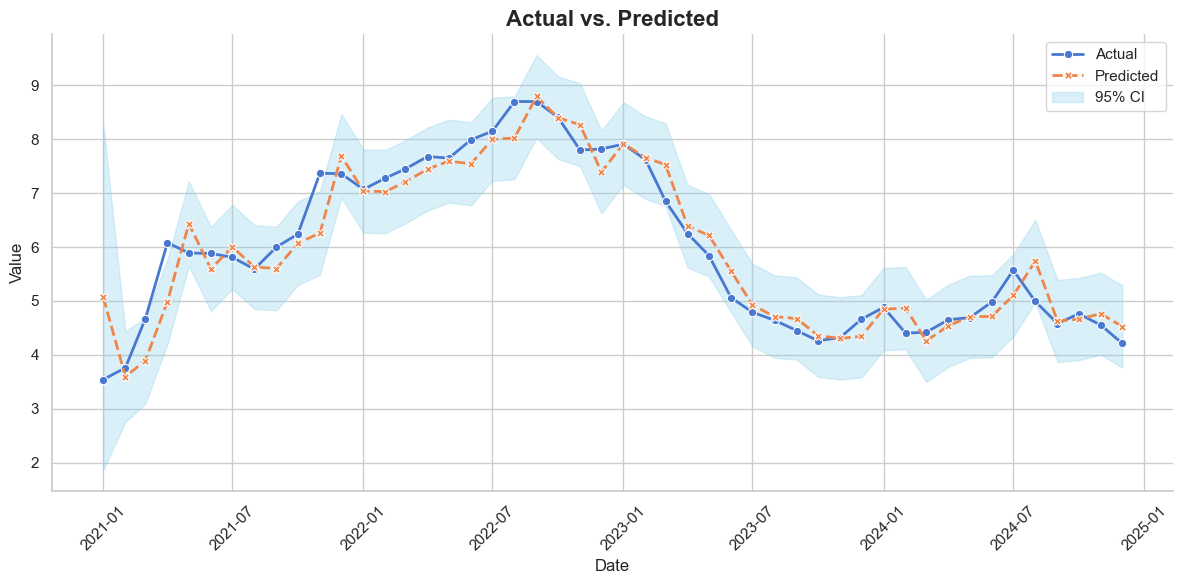

In [16]:
### Plot actual vs. predicted
# Set a nice theme
sns.set_theme(style="whitegrid", palette="muted")

# Ensure datetime index
df_eval_prediction.index = pd.to_datetime(df_eval_prediction.index)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual
sns.lineplot(
    x=df_eval_prediction.index,
    y=df_eval_prediction['y'],
    label='Actual',
    marker='o',
    linewidth=2
)

# Plot predicted
sns.lineplot(
    x=df_eval_prediction.index,
    y=df_eval_prediction['y_hat'],
    label='Predicted',
    linestyle='--',
    marker='X',
    linewidth=2
)

# Plot confidence interval manually
plt.fill_between(
    df_eval_prediction.index,
    df_eval_prediction['lower_y'],
    df_eval_prediction['upper_y'],
    color='skyblue',
    alpha=0.3,
    label='95% CI'
)

# Titles and labels
plt.title('Actual vs. Predicted', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Ticks and legend
plt.xticks(rotation=45)
plt.legend(frameon=True)
sns.despine()
plt.tight_layout()
plt.show()


### Train-Test Metrics

In [17]:
# Import required tools
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error


# Train function
def ARIMA_EVAL_TAIN_TEST(endog, best_pIq, bc, test_size, freq):
    """
    ARIMA training function

    IN:
    -> endog: endogenous variables at present time (pd.Series)
    -> best_pIq: p,I,q model parameters in that order (list)
    -> bc_transform: whether to apply Box-Cox transformation (bool)
    -> test_size : last months to evaluate model (str)
    -> freq: frequency of the time series data (str)

    PRINTS:
    MAPE, R2, MAE on test set

    OUT:
    -> df_eval_forecast : table with the actual data and the predicted and forecasted data (pd.DataFrame)
    """ 
    ### Prepare data
    # Initialize training data
    full_index = endog.index
    endog_train = endog.head(endog.shape[0] - test_size)
    train_index = endog_train.index
    endog_test = endog.tail(test_size)
    test_index = endog_test.index

    # Initialize parameters
    p = best_pIq[0]
    I = best_pIq[1]
    q = best_pIq[2]

     # Handle Box-Cox transformation
    if bc:
        endog_train, l = boxcox(endog_train)
        endog_train = pd.Series(endog_train, index = train_index)



    ### Train model
     # Handle trend term
    if I > 0:
        trend = None
    else:
        trend = 'c'
                
    # Set model
    model = SARIMAX(
         endog = endog_train, 
         order = (p, I, q),
         trend = trend,
         freq = freq
         )

    # Train model
    results = model.fit()



    ### Get forecasted values and actual values
    # Get predicted values
    predicted_full = results.get_prediction()
    predicted = predicted_full.predicted_mean
    ci_predicted = predicted_full.conf_int()
    # Get forecasted values
    forecasted_full = results.get_forecast(steps = test_size)
    forecasted = forecasted_full.predicted_mean
    ci_forecasted = forecasted_full.conf_int()

    # Handle inverse Box-Cox transformation
    if bc:
        predicted = inv_boxcox(predicted, l)
        predicted = pd.Series(predicted, index = train_index)
        ci_predicted['lower y'] = inv_boxcox(ci_predicted['lower y'], l)
        ci_predicted['upper y'] = inv_boxcox(ci_predicted['upper y'], l)
        forecasted = inv_boxcox(forecasted, l)
        forecasted = pd.Series(forecasted, index = test_index)
        ci_forecasted['lower y'] = inv_boxcox(ci_forecasted['lower y'], l)
        ci_forecasted['upper y'] = inv_boxcox(ci_forecasted['upper y'], l)

    # Get actual values
    actual = endog_test

    # Set table with results
    full = endog
    full_hat = pd.concat([predicted, forecasted], axis = 0)
    ci_full = pd.concat([ci_predicted, ci_forecasted], axis = 0)
    dict_eval_forecast = {
        'y' : full,
        'y_hat' : full_hat, 
        'lower_y' : ci_full['lower y'],
        'upper_y' : ci_full['upper y'] 
    }
    df_eval_forecast = pd.DataFrame(dict_eval_forecast, index = full_index)
    


    ### Calculate metrics
    print('-------------------------------')
    print('MAPE: ', mean_absolute_percentage_error(actual, forecasted))
    print('R2: ', r2_score(actual, forecasted))
    print('MAE: ', mean_absolute_error(actual, forecasted))
    print('--------------------------------')

    return df_eval_forecast

In [18]:
# Evaluate model through train-test split
best_pIq = [2,0,2]
test_size = 6
bc = False
freq = 'MS'
df_eval_forecast = ARIMA_EVAL_TAIN_TEST(endog = endog, best_pIq = best_pIq, bc = bc, test_size = test_size, freq = freq)
df_eval_forecast.head()

-------------------------------
MAPE:  0.15362613186239574
R2:  -2.4338720942811967
MAE:  0.7029629472291069
--------------------------------


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

,y,y_hat,lower_y,upper_y
ds,,,,
2021-01-01,3.54,5.839428,2.846007,8.832848
2021-02-01,3.76,3.628208,2.807059,4.449358
2021-03-01,4.67,3.963208,3.214907,4.711508
2021-04-01,6.08,5.106676,4.358775,5.854576
2021-05-01,5.89,6.651152,5.909155,7.393149


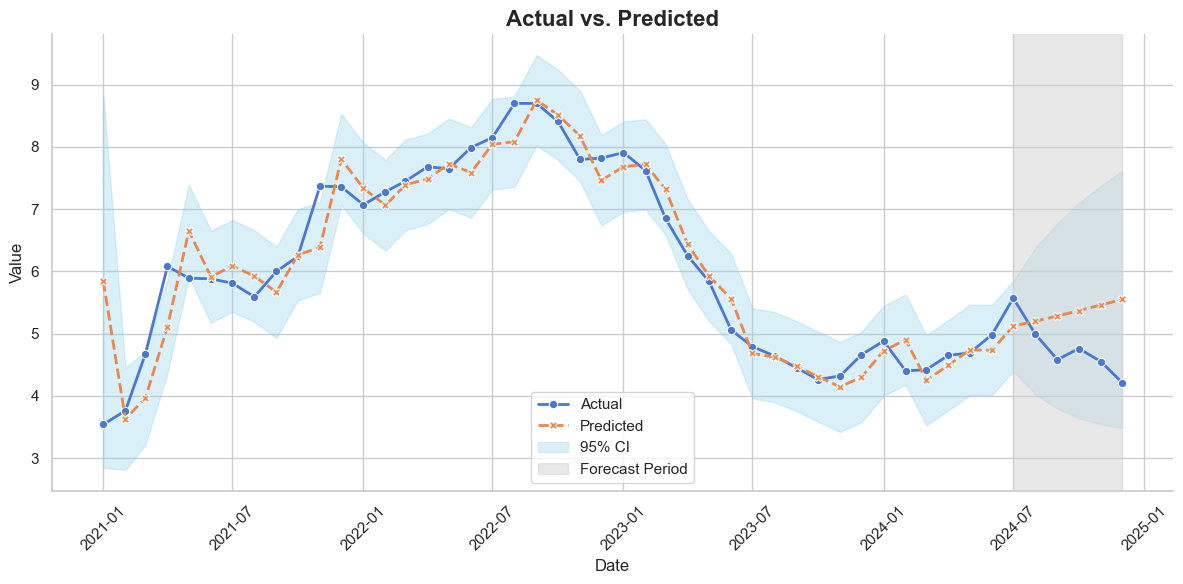

In [19]:
### Plot actual vs. predicted and forecasted
# Set a nice theme
sns.set_theme(style="whitegrid", palette="muted")

# Ensure datetime index
df_eval_forecast.index = pd.to_datetime(df_eval_forecast.index)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual
sns.lineplot(
    x=df_eval_forecast.index,
    y=df_eval_forecast['y'],
    label='Actual',
    marker='o',
    linewidth=2
)

# Plot predicted
sns.lineplot(
    x=df_eval_forecast.index,
    y=df_eval_forecast['y_hat'],
    label='Predicted',
    linestyle='--',
    marker='X',
    linewidth=2
)

# Plot confidence interval manually
plt.fill_between(
    df_eval_forecast.index,
    df_eval_forecast['lower_y'],
    df_eval_forecast['upper_y'],
    color='skyblue',
    alpha=0.3,
    label='95% CI'
)

# 👉 Highlight forecast region
forecast_start = df_eval_forecast.index[-6]
forecast_end = df_eval_forecast.index[-1]
plt.axvspan(
    forecast_start, forecast_end,
    color='lightgrey',
    alpha=0.5,
    label='Forecast Period'
)

# Titles and labels
plt.title('Actual vs. Predicted', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Ticks and legend
plt.xticks(rotation=45)
plt.legend(frameon=True)
sns.despine()
plt.tight_layout()
plt.show()


### Assumptions Verification

## Model Use
This section predict future values with it's required confidenc intervals.

In [20]:
# Impomrt required tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

def ARIMA_FORECAST(endog, n_periods, best_pIq, bc, freq):
    """
    ARIMA forecsting function

    IN:
    -> endog: endogenous variables at present time (pd.Series)
    -> n_periods : periods to forecast (int)
    -> best_pIq: p,I,q model parameters in that order (list)
    -> bc_transform: whether to apply Box-Cox transformation or not (bool)
    -> freq: frequency of the time series data (str)

    OUT:
    -> df_eval_forecast : table with the actual data and the predicted and forecasted data. Note there won't be actual data for forecasting periods (pd.DataFrame)
    """ 
    ### Prepare data
    # Initialize training data
    endog_train = endog.copy()
    train_index = endog_train.index
    forecast_index = pd.date_range(
    start = endog.index[-1] + pd.tseries.frequencies.to_offset(freq),
    periods = n_periods,
    freq = freq)
    full_index = train_index.append(forecast_index)

    # Initialize parameters
    p = best_pIq[0]
    I = best_pIq[1]
    q = best_pIq[2]

     # Handle Box-Cox transformation
    if bc:
        endog_train, l = boxcox(endog_train)
        endog_train = pd.Series(endog_train, index = train_index)



    ### Train model
     # Handle trend term
    if I > 0:
        trend = None
    else:
        trend = 'c'
                
    # Set model
    model = SARIMAX(
         endog = endog_train, 
         order = (p, I, q),
         trend = trend,
         freq = freq
         )

    # Train model
    results = model.fit()



    ### Predict and forecast
    # Get predicted values
    predicted_full = results.get_prediction()
    predicted = predicted_full.predicted_mean
    ci_predicted = predicted_full.conf_int()
    # Get forecasted values
    forecasted_full = results.get_forecast(steps = n_periods)
    forecasted = forecasted_full.predicted_mean
    ci_forecasted = forecasted_full.conf_int()

    # Handle inverse Box-Cox transformation
    if bc:
        predicted = inv_boxcox(predicted, l)
        predicted = pd.Series(predicted, index = train_index)
        ci_predicted['lower y'] = inv_boxcox(ci_predicted['lower y'], l)
        ci_predicted['upper y'] = inv_boxcox(ci_predicted['upper y'], l)
        forecasted = inv_boxcox(forecasted, l)
        forecasted = pd.Series(forecasted, index = forecast_index)
        ci_forecasted['lower y'] = inv_boxcox(ci_forecasted['lower y'], l)
        ci_forecasted['upper y'] = inv_boxcox(ci_forecasted['upper y'], l)

    # Set table with results
    full = pd.concat([endog, pd.Series([np.nan]*n_periods, index = forecast_index)], axis = 0)
    full_hat = pd.concat([predicted, forecasted], axis = 0)
    ci_full = pd.concat([ci_predicted, ci_forecasted], axis = 0)
    dict_forecast = {
        'y' : full,
        'y_hat' : full_hat, 
        'lower_y' : ci_full['lower y'],
        'upper_y' : ci_full['upper y'], 
    }
    df_forecast = pd.DataFrame(dict_forecast, index = full_index)

    return df_forecast

In [21]:
# Forecast
n_periods = 6
best_pIq = [2,0,2]
bc = False
freq = 'MS'
df_forecast = ARIMA_FORECAST(endog = endog, n_periods = n_periods, best_pIq = best_pIq, bc = bc, freq = freq)
df_forecast.tail(n_periods*2)

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

,y,y_hat,lower_y,upper_y
2024-07-01,5.57,5.102305,4.340002,5.864609
2024-08-01,4.99,5.740120,4.977956,6.502284
2024-09-01,4.58,4.626721,3.864692,5.388750
2024-10-01,4.76,4.662337,3.900437,5.424236
2024-11-01,4.55,4.762531,4.000756,5.524306
2024-12-01,4.21,4.523992,3.762338,5.285647
2025-01-01,NaN,4.095034,3.333496,4.856572
2025-02-01,NaN,4.190777,2.877984,5.503569
2025-03-01,NaN,4.207361,2.587362,5.827359
2025-04-01,NaN,4.284466,2.409582,6.159351


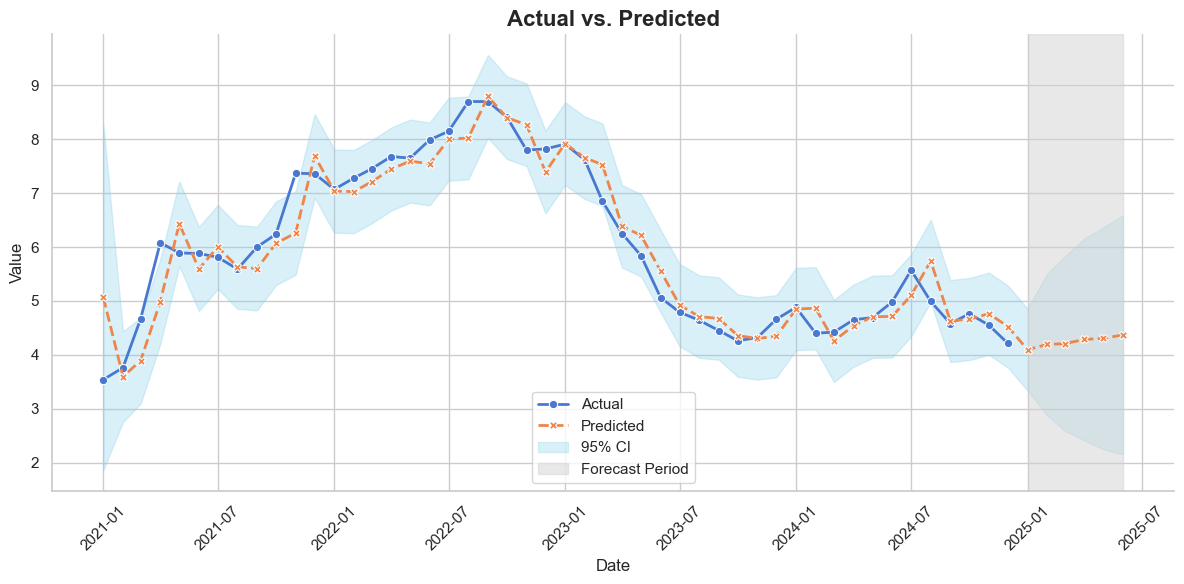

In [22]:
### Plot actual vs. predicted and forecasted
# Set a nice theme
sns.set_theme(style="whitegrid", palette="muted")

# Ensure datetime index
df_forecast.index = pd.to_datetime(df_forecast.index)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual
sns.lineplot(
    x=df_forecast.index,
    y=df_forecast['y'],
    label='Actual',
    marker='o',
    linewidth=2
)

# Plot predicted
sns.lineplot(
    x=df_forecast.index,
    y=df_forecast['y_hat'],
    label='Predicted',
    linestyle='--',
    marker='X',
    linewidth=2
)

# Plot confidence interval manually
plt.fill_between(
    df_forecast.index,
    df_forecast['lower_y'],
    df_forecast['upper_y'],
    color='skyblue',
    alpha=0.3,
    label='95% CI'
)

# 👉 Highlight forecast region
forecast_start = df_forecast.index[-n_periods]
forecast_end = df_forecast.index[-1]
plt.axvspan(
    forecast_start, forecast_end,
    color='lightgrey',
    alpha=0.5,
    label='Forecast Period'
)

# Titles and labels
plt.title('Actual vs. Predicted', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Ticks and legend
plt.xticks(rotation=45)
plt.legend(frameon=True)
sns.despine()
plt.tight_layout()
plt.show()


In [23]:
# Evaluate since we know the future data
print('-------------------------------')
print('MAPE: ', mean_absolute_percentage_error(endog_future, df_forecast['y_hat'].tail(6)))
print('R2: ', r2_score(endog_future, df_forecast['y_hat'].tail(6)))
print('MAE: ', mean_absolute_error(endog_future, df_forecast['y_hat'].tail(6)))
print('--------------------------------')

-------------------------------
MAPE:  0.08113513048432068
R2:  -0.3690269623575295
MAE:  0.3084339102412004
--------------------------------


## Pendientes
* Evaluar supuestos del modelo